# Setup do ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
import warnings

warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 7)

print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


# Carregamento dos Dados

## Carregar o dataset


Carregar o dataset diretamente do [Github](https://github.com/diegonogare/Workshop-AnalisePreditivaDeManutencao/blob/main/conjuntoDados.csv).

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/diegonogare/Workshop-AnalisePreditivaDeManutencao/refs/heads/main/conjuntoDados.csv',
                 names=['ID', 'Timestamp', 'Temperatura', 'Sinais', 'Desligou'])

In [3]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Dia'] = df['Timestamp'].dt.day
df['DiaSemana'] = df['Timestamp'].dt.day_name()
df['Hora'] = df['Timestamp'].dt.time

df = df[df['Dia'] != (7)]
df = df[df['Dia'] != (29)]


## Conhecer o básico do dataset

Após o dataset ser carregado, é importante analisar seu conteúdo para conhecer o que há lá dentro.

In [5]:
print("\nDataset carregado com sucesso!")
print("Formato do dataset (linhas x colunas):", df.shape)

print("\nPrimeiras 5 linhas do dataset:")
print(df.head())

print("\nInformações do dataset:")
df.info()

print("\nEstatística descritivas:")
print(df.describe())

print("\nValores nulos por Coluna:")
print(df.isnull().sum())


Dataset carregado com sucesso!
Formato do dataset (linhas x colunas): (120960, 8)

Primeiras 5 linhas do dataset:
   ID           Timestamp  Temperatura  Sinais  Desligou  Dia DiaSemana  \
0   1 2018-04-30 02:36:00        19.59       5         0   30    Monday   
1   2 2018-04-30 02:36:05        19.18       4         0   30    Monday   
2   3 2018-04-30 02:36:10        19.38       3         0   30    Monday   
3   4 2018-04-30 02:36:15        19.26       4         0   30    Monday   
4   5 2018-04-30 02:36:20        19.52       5         0   30    Monday   

       Hora  
0  02:36:00  
1  02:36:05  
2  02:36:10  
3  02:36:15  
4  02:36:20  

Informações do dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 120960 entries, 0 to 131583
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   ID           120960 non-null  int64         
 1   Timestamp    120960 non-null  datetime64[ns]
 2   Temperatura  12

# Análise Exploratória Descritiva (EDA)

In [6]:
colunas_numericas = df.select_dtypes(include=np.number).columns.tolist()
colunas_numericas

colunas_numericas.remove('ID') #ID da transação
colunas_numericas.remove('Desligou') #Flag se desligou ou não
colunas_numericas


['Temperatura', 'Sinais', 'Dia']

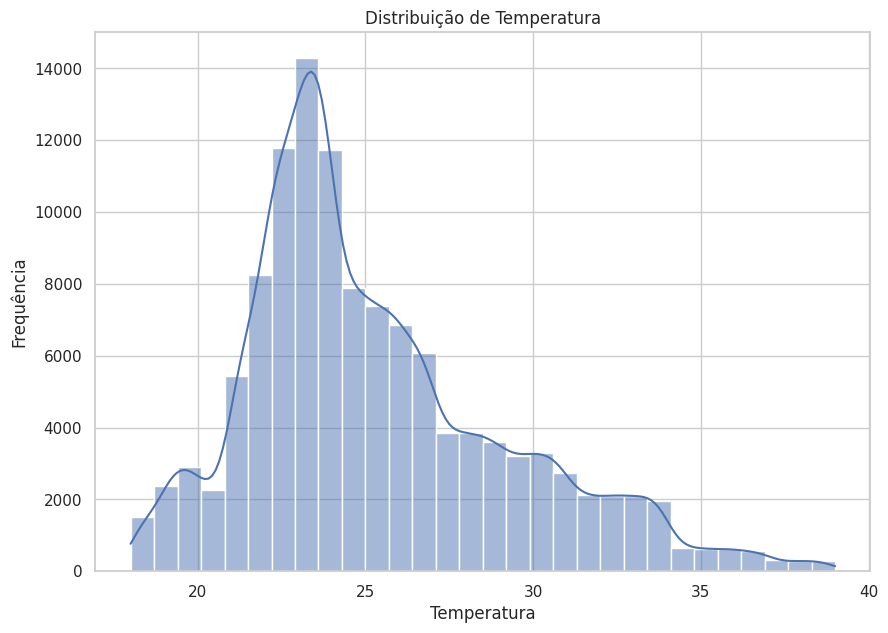

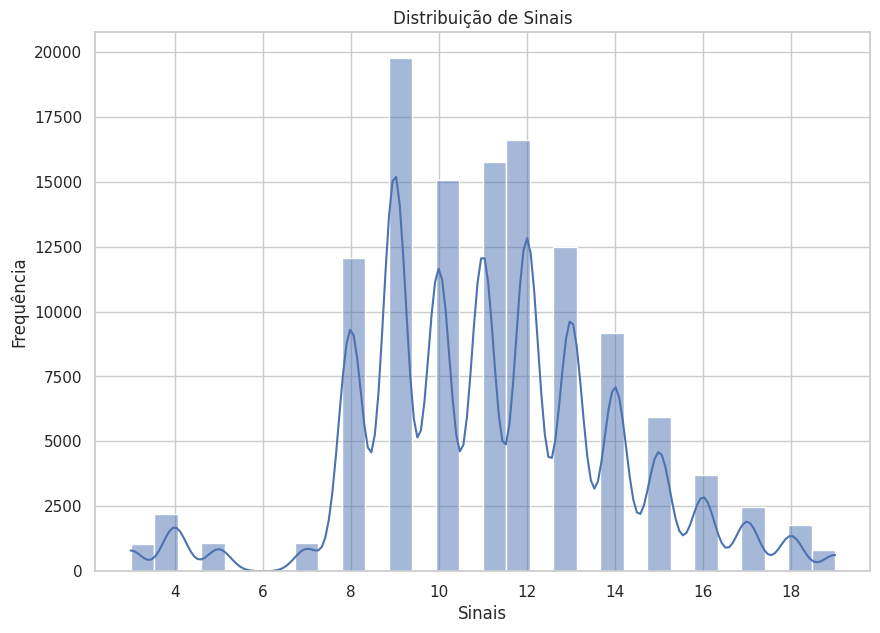

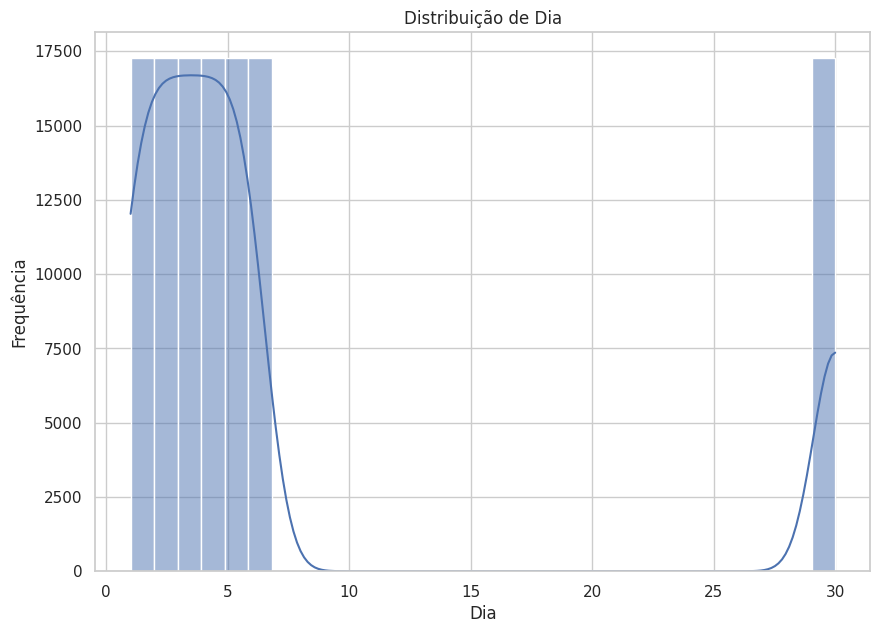

In [7]:
for col in colunas_numericas:
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()
    print("\n")

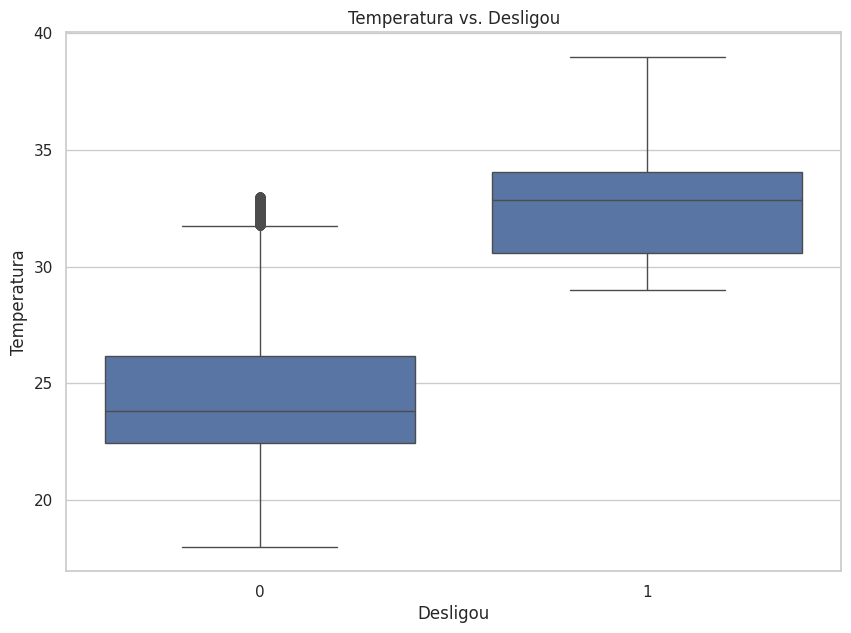

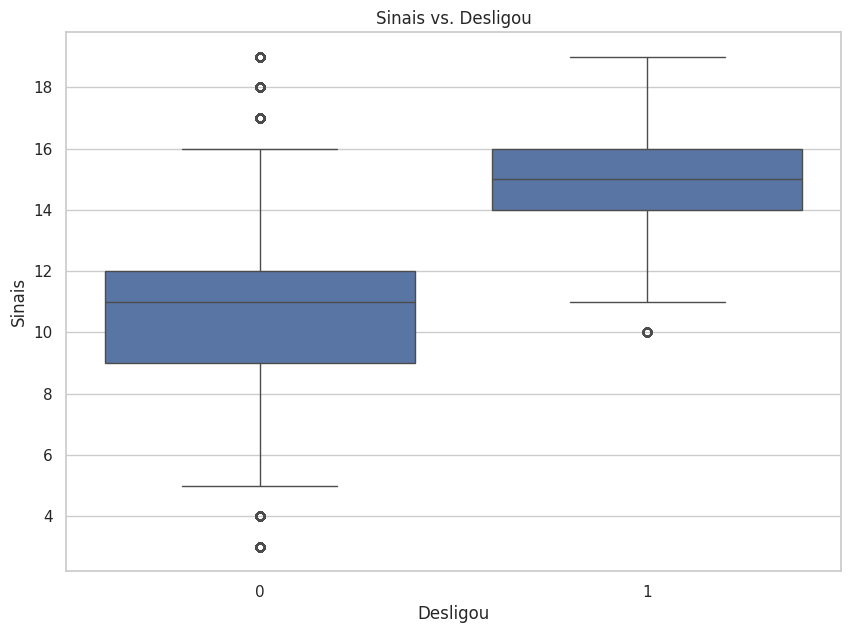

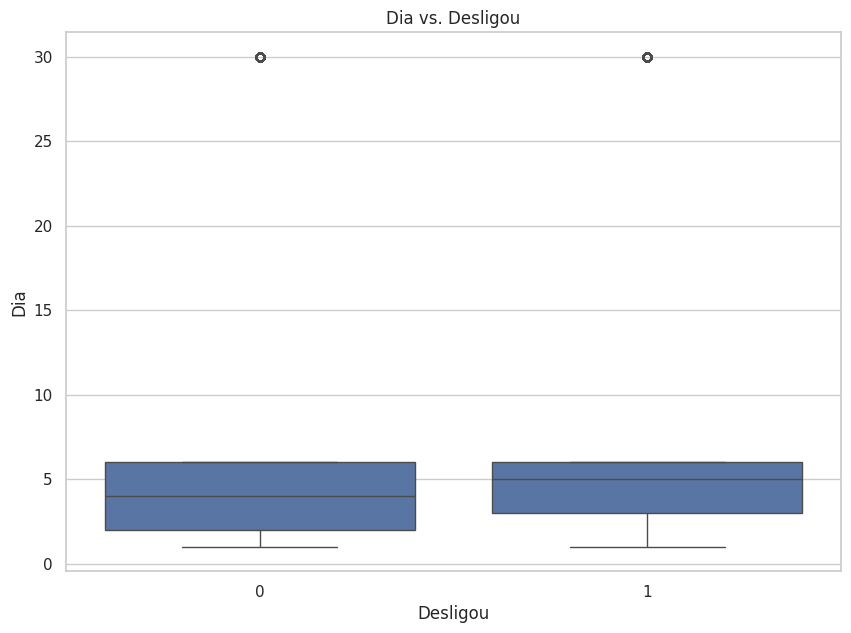

In [8]:
for col in colunas_numericas:
    sns.boxplot(x='Desligou', y=col, data=df)
    plt.title(f'{col} vs. Desligou')
    plt.show()
    print("\n")

In [ ]:
#Pela exploração que fizemos, apesar de Dia ser um valor numério, não tem relação com o objetivo que temos. Vamos remover
colunas_numericas.remove('Dia')

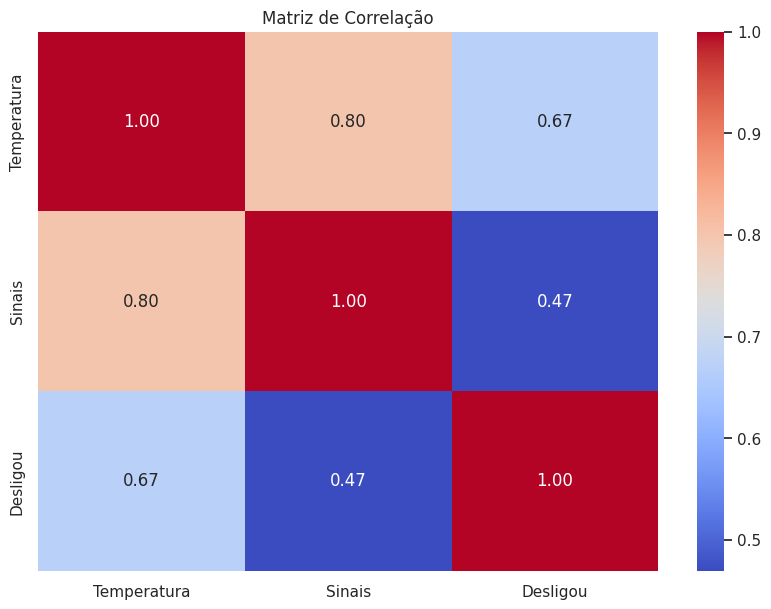

In [10]:
correlation_matrix = df[colunas_numericas + ['Desligou']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()

### 1 - Quais horários a temperatura da fábrica é mais alta?

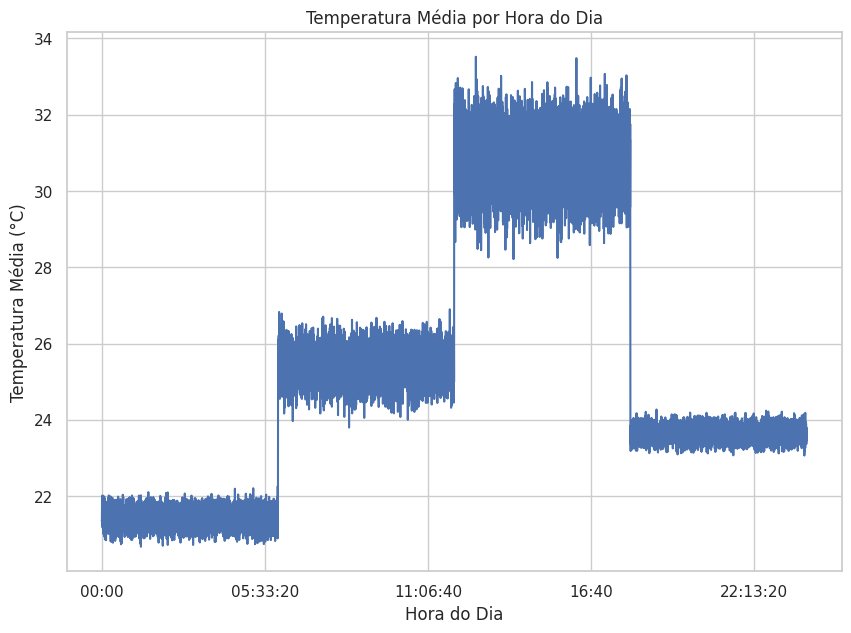

In [11]:
temperatura = df.copy()
temperatura.drop(columns=['Timestamp', 'Dia', 'Sinais', 'Desligou'], inplace=True )

temperatura.groupby('Hora')['Temperatura'].mean('Temperatura').plot(kind='line', marker='')
plt.title('Temperatura Média por Hora do Dia')
plt.xlabel('Hora do Dia')
plt.ylabel('Temperatura Média (°C)')
plt.grid(True)
plt.show()


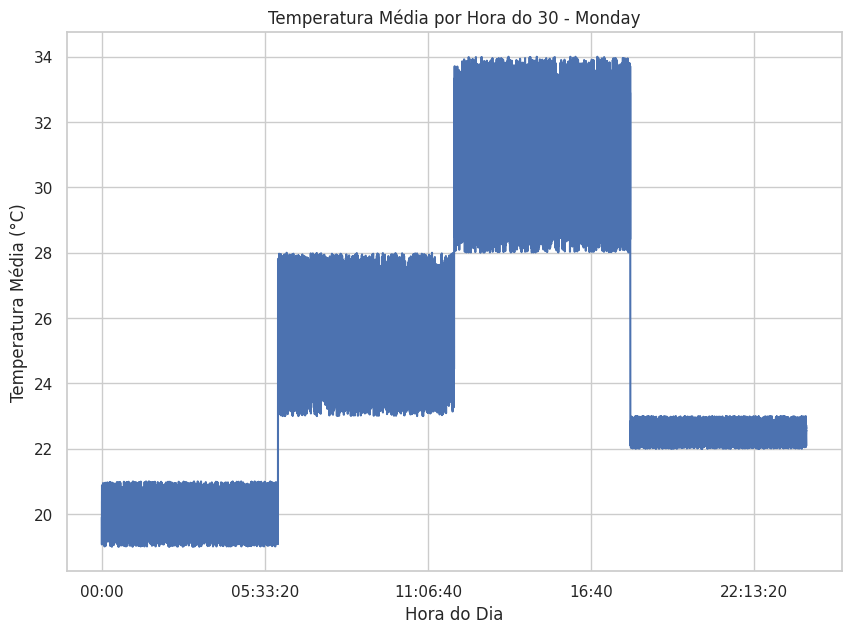

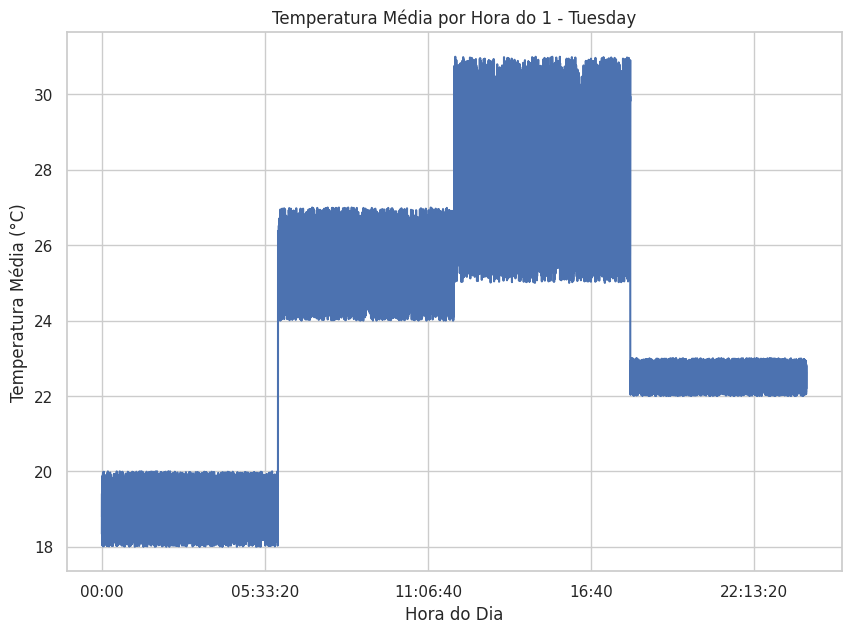

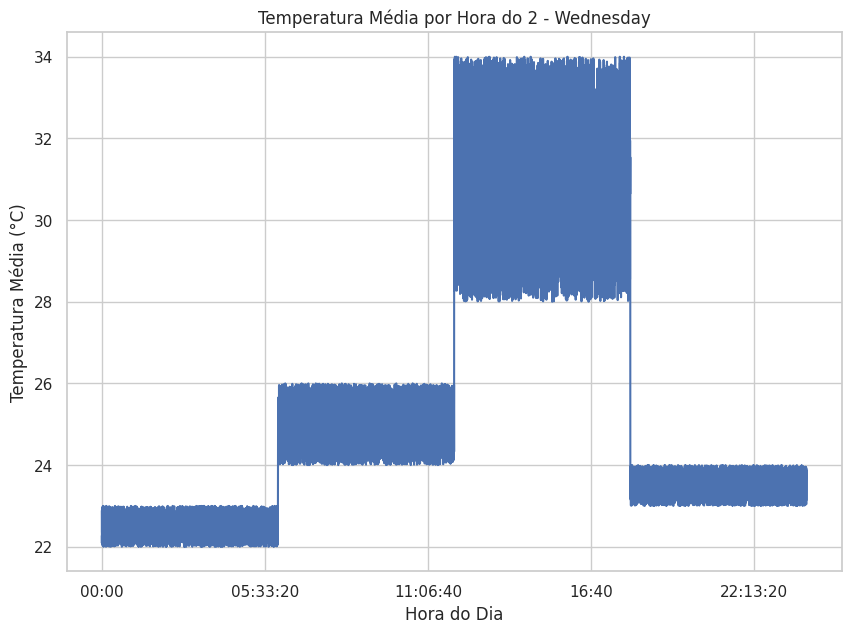

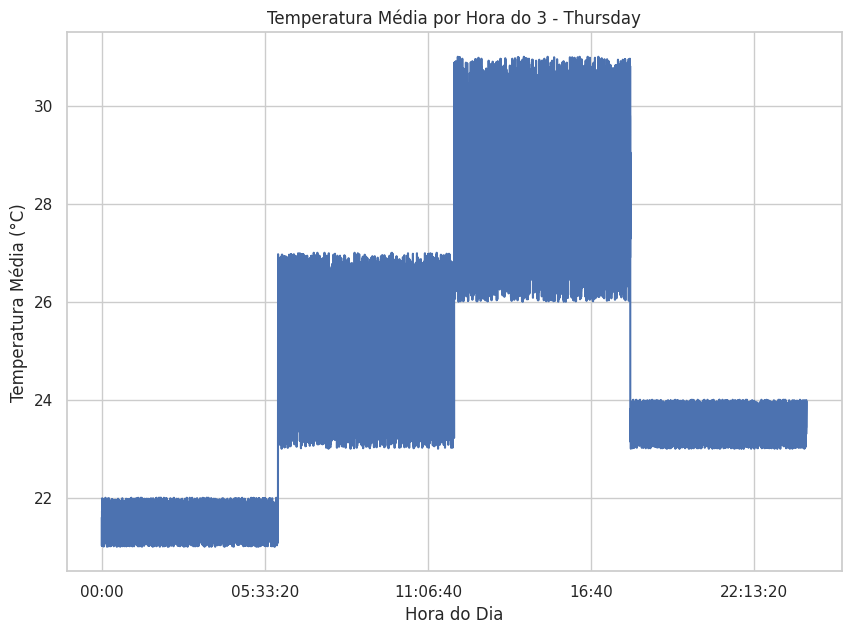

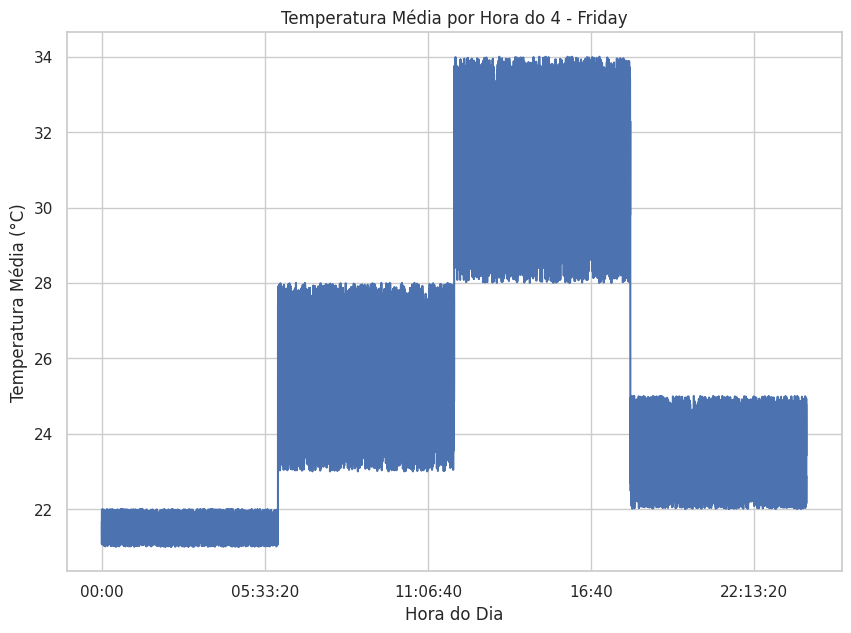

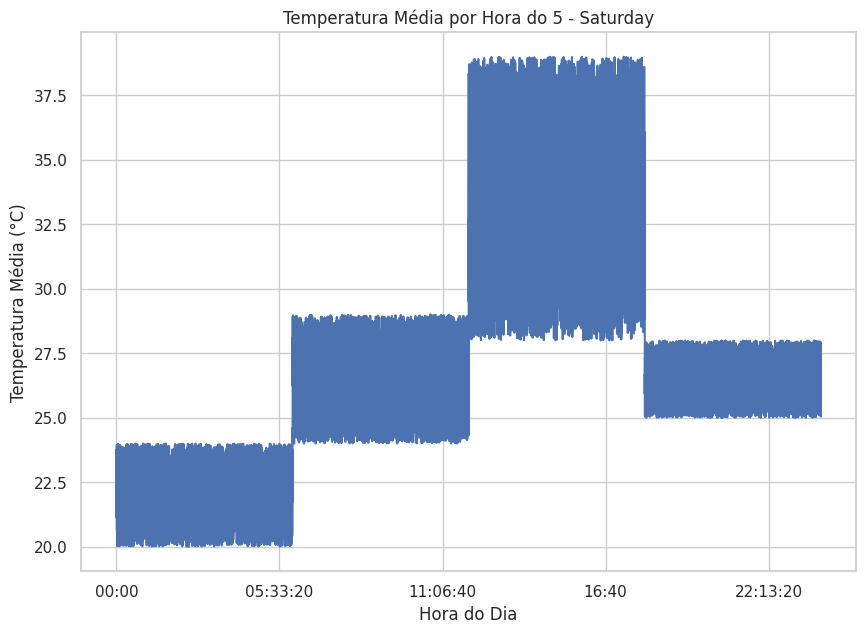

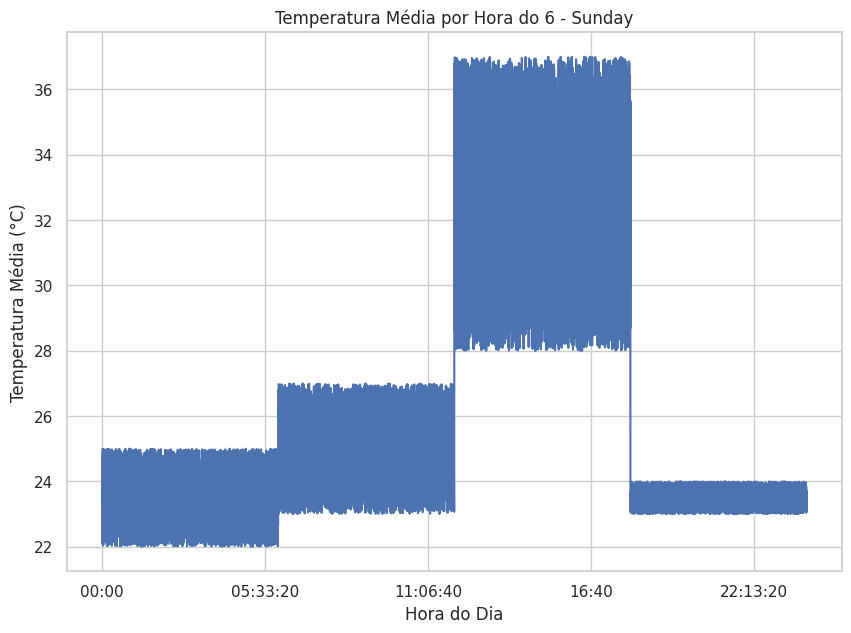

In [12]:
for dia in df['Dia'].unique():
    temperaturaDiaria = df.copy()
    temperaturaDiaria = temperaturaDiaria[temperaturaDiaria['Dia'] == dia]
    temperaturaDiaria.drop(columns=['Timestamp', 'Sinais', 'Desligou'], inplace=True )
    diaSemana = temperaturaDiaria['DiaSemana'].iloc[0]

    temperaturaDiaria.groupby('Hora')['Temperatura'].mean('Temperatura').plot(kind='line', marker='')
    plt.title(f'Temperatura Média por Hora do {dia} - {diaSemana}')
    plt.xlabel('Hora do Dia')
    plt.ylabel('Temperatura Média (°C)')
    plt.grid(True)
    plt.show()

    print("\n")


### 2 - Quais temperaturas normalmente levam a máquina a parar de funcionar?


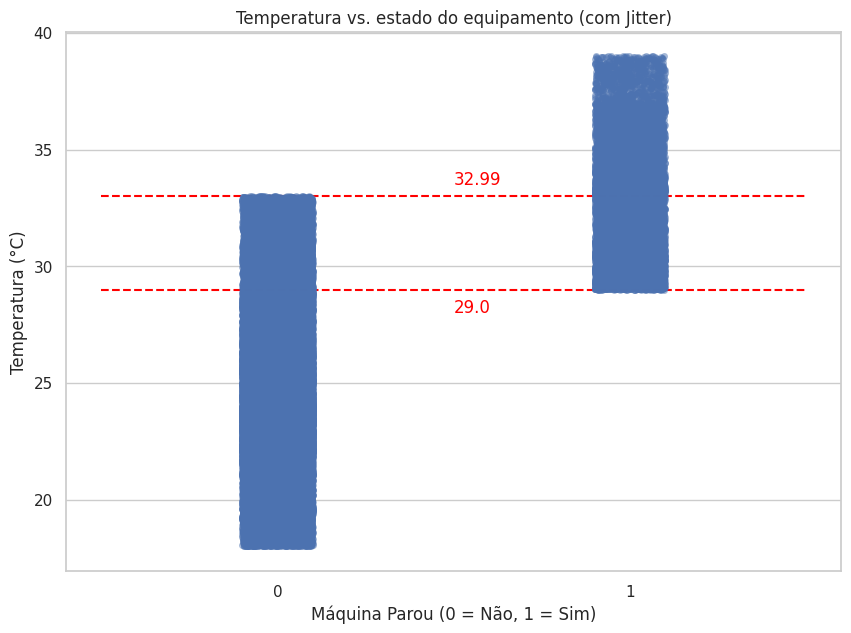

In [13]:
maxFuncionando = df[df['Desligou'] == 0]['Temperatura'].max()
minNaoFuncionando = df[df['Desligou'] == 1]['Temperatura'].min()

sns.stripplot(x='Desligou', y='Temperatura', data=df, jitter=True, alpha=0.5)
plt.title('Temperatura vs. estado do equipamento (com Jitter)')
plt.xlabel('Máquina Parou (0 = Não, 1 = Sim)')
plt.ylabel('Temperatura (°C)')
plt.hlines(y=[maxFuncionando, minNaoFuncionando], xmin=-0.5, xmax=1.5, colors='red', linestyles='dashed')
plt.text(x=0.5, y=minNaoFuncionando - 1, s=minNaoFuncionando, color='red' )
plt.text(x=0.5, y=maxFuncionando + 0.5, s=maxFuncionando, color='red' )
plt.show()

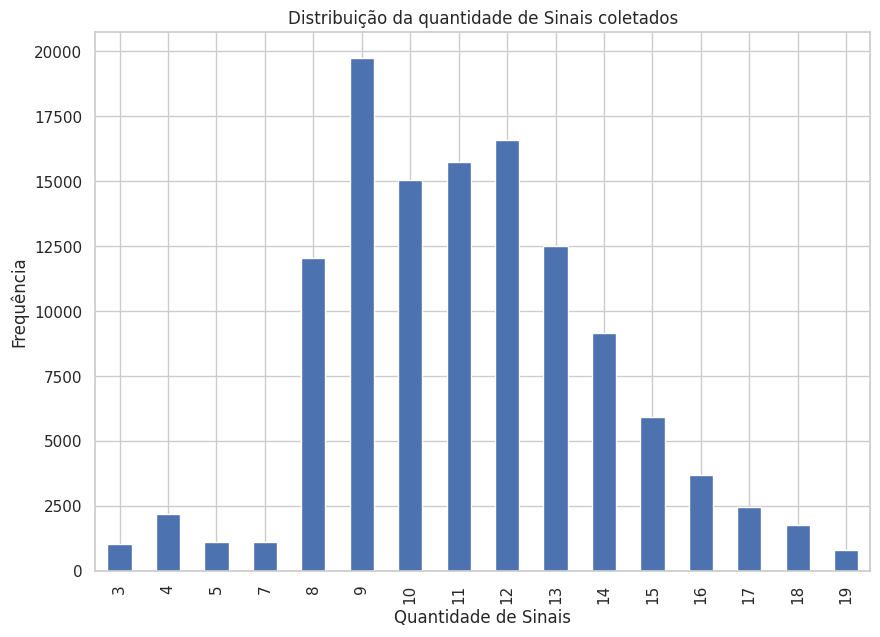

In [14]:
df['Sinais'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuição da quantidade de Sinais coletados')
plt.xlabel('Quantidade de Sinais')
plt.ylabel('Frequência')
plt.show()

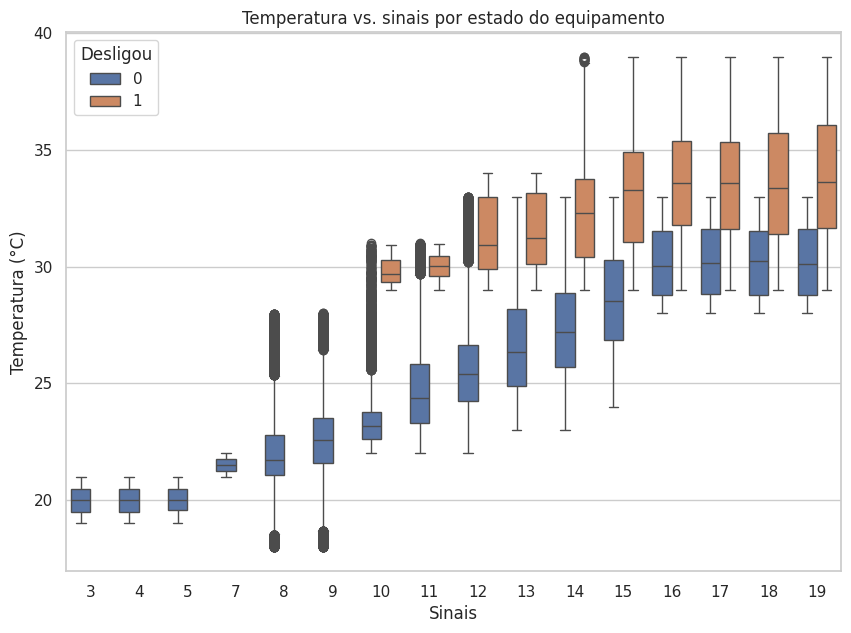

In [19]:
sns.boxplot(x='Sinais', y='Temperatura', hue='Desligou', data=df)
plt.title('Temperatura vs. sinais por estado do equipamento')
plt.xlabel('Sinais')
plt.ylabel('Temperatura (°C)')
plt.legend(title='Desligou')
plt.show()


# Classificação com Regressão Logística

# Detecção de Anomalias com Isolation Forest